In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best Parameters for KNN: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'metric': 'euclidean'}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.50      0.40      0.44         5
           2       0.67      0.67      0.67         6
           3       0.50      0.17      0.25         6
           4       0.33      0.40      0.36         5
           5       0.38      0.75      0.50         4
           6       1.00      0.67      0.80         3
           7       0.50      0.67      0.57         3

    accuracy                         

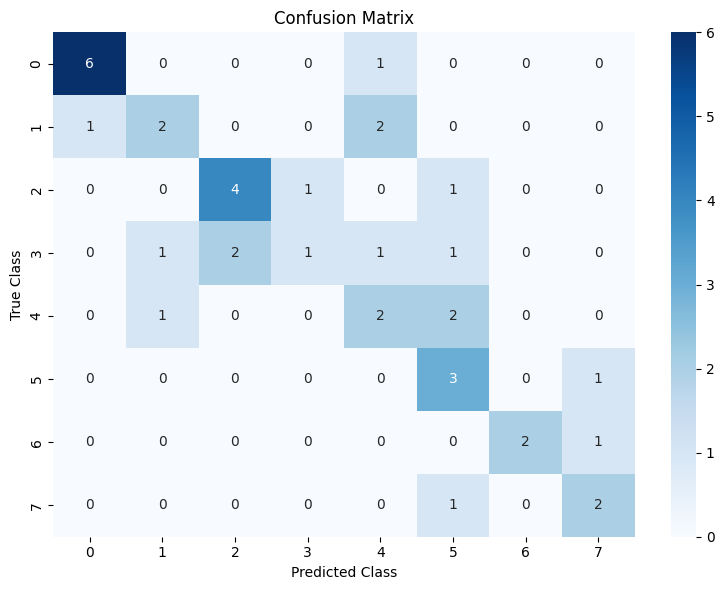

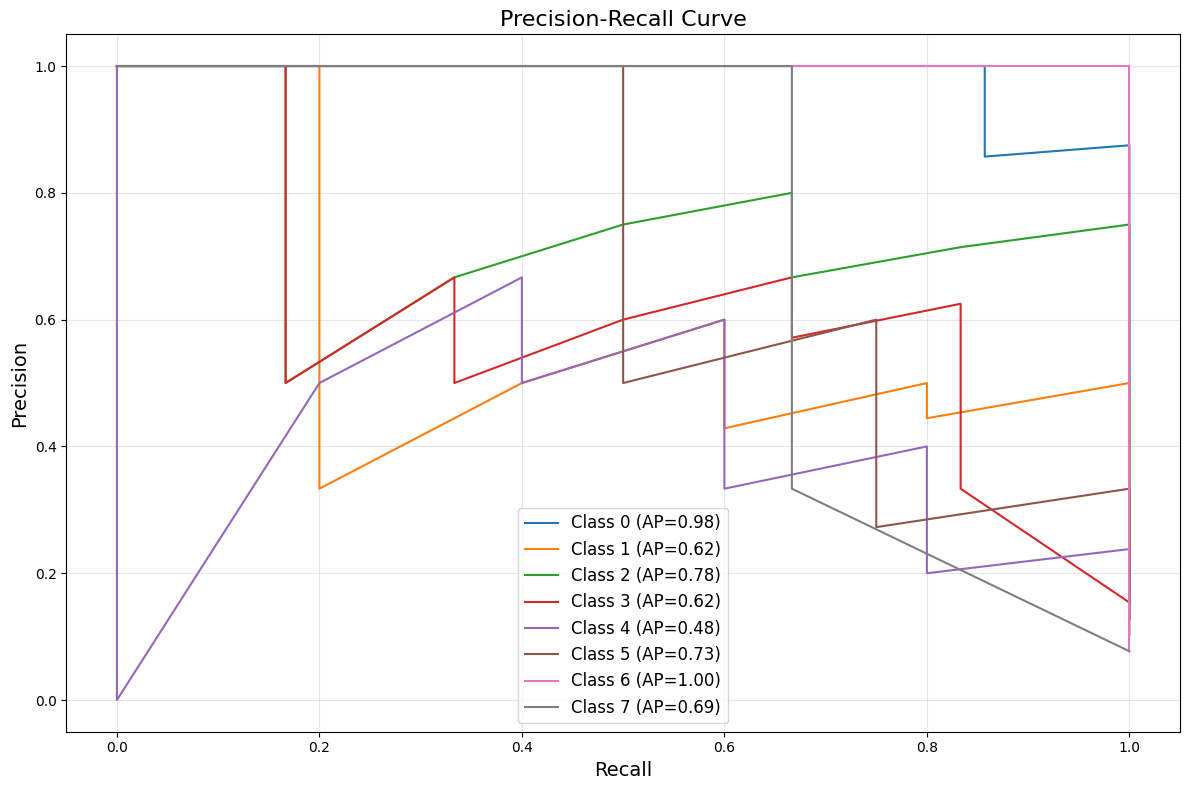


Overall PR AUC (Macro Average): 0.74
Permutation Importance for KNN:
               Feature  Importance
19  chronic_conditions    0.188034
5    sports_experience    0.093162
4        resting_pulse    0.062393
7                goals    0.028205
6             body_fat    0.016239
10      W/Height_Ratio    0.007692
12             chest_c    0.001709
2               weight    0.000855
1               height    0.000855
18           lower_leg   -0.000855
0               gender   -0.000855
14          left_arm_c   -0.005983
16               hip_c   -0.006838
17         upper_leg_c   -0.007692
15             waist_c   -0.009402
13         right_arm_c   -0.011966
8                  BMI   -0.013675
11          shoulder_c   -0.019658
3                  age   -0.026496
20           surgeries   -0.033333
9          W/Hip_Ratio   -0.045299


C:\Users\licop\AppData\Local\Temp\ipykernel_30040\3906755495.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=knn_importances, x='Importance', y='Feature', palette='viridis')


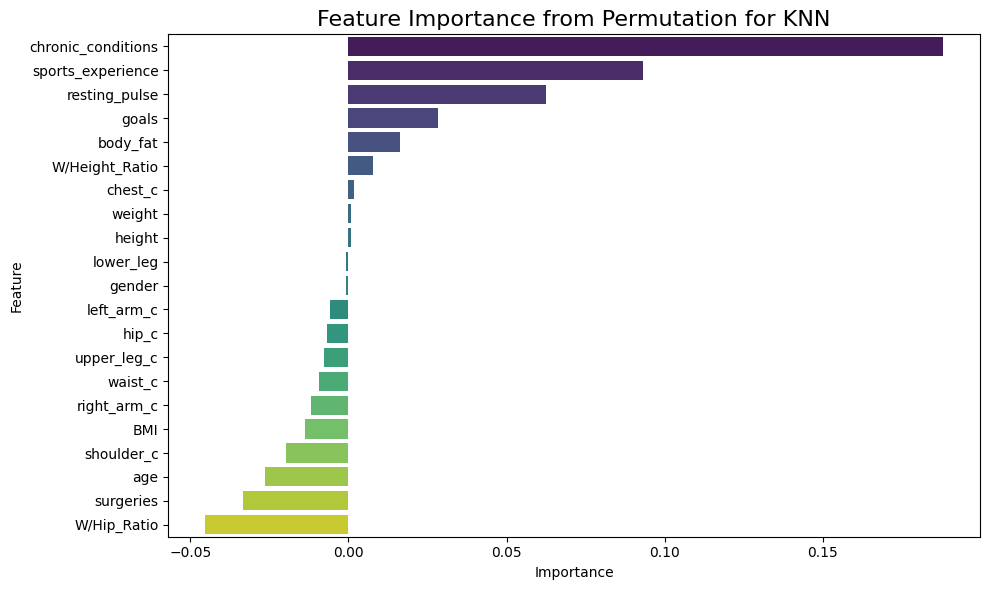

In [3]:
# Define the seed for reproducibility
seed = 12  # Set the seed here

# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define hyperparameters for optimization
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # for Manhattan (1) and Euclidean (2)
}

# Perform Randomized Search with Cross-Validation
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=4,
    random_state=seed,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search_knn.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters for KNN:", random_search_knn.best_params_)

# Evaluate the best model
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Precision-Recall Curve and PR AUC Calculation
# Binarize the output (One-vs-Rest approach for multi-class Precision-Recall)
y_test_binarized = label_binarize(y_test, classes=best_knn.classes_)
y_prob_knn = best_knn.predict_proba(X_test)  # Get class probabilities

# Initialize plot for PR Curve
plt.figure(figsize=(12, 8))

# Loop through each class
for i, class_label in enumerate(best_knn.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob_knn[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_prob_knn[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP={auc_score:.2f})')

# Plot settings
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display overall Average Precision Score (macro average)
overall_pr_auc = average_precision_score(y_test_binarized, y_prob_knn, average="macro")
print(f"\nOverall PR AUC (Macro Average): {overall_pr_auc:.2f}")

# Calculate Permutation Importance
perm_importance_knn = permutation_importance(best_knn, X_test, y_test, n_repeats=30, random_state=seed)

# Store permutation importance in a DataFrame
knn_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_knn.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Permutation Importance for KNN:")
print(knn_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=knn_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Permutation for KNN', fontsize=16)
plt.tight_layout()
plt.show()
